In [1]:
from os import path as osp
import numpy as np
import tensorflow as tf
import sonnet as snt
from attrdict import AttrDict

from tensorflow.contrib.distributions import Bernoulli, NormalWithSoftplusScale, Normal
from tensorflow.contrib.distributions.python.ops.kullback_leibler import kl as _kl

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
% matplotlib inline

from neurocity import minimize_clipped
from neurocity.tools.params import num_trainable_params

from tf_tools.eval import make_expr_logger, gradient_summaries

from data import load_data, tensors_from_data
from model import AIRCell
from ops import Loss
from prior import geometric_prior, presence_prob_table, tabular_kl, NumStepsDistribution

In [2]:
learning_rate = 1e-4
batch_size = 64
img_size = 50, 50
crop_size = 20, 20
n_latent = 50
n_hidden = 256
n_steps = 3

results_dir = '../results'
run_name = 'test'

logdir = osp.join(results_dir, run_name)
checkpoint_name = osp.join(logdir, 'model.ckpt')
axes = {'imgs': 0, 'labels': 0, 'nums': 1}

In [3]:
output_std = .3

use_prior = True

num_steps_prior = AttrDict(
    anneal='linear',
    init=.9,
    final=1e-5,
    steps_div=1e4,
    steps=1e5
)

latent_code_prior = AttrDict(loc=0., scale=1.)
where_scale_prior = AttrDict(loc=.0, scale=2.)
where_shift_prior = AttrDict(loc=.0, scale=2.)

use_reinforce = True
sample_presence = True
presence_bias = 0.

init_explore_eps = .00

l2_weight = 0. #1e-5

In [4]:
test_data = load_data('mnist_test.pickle')
train_data = load_data('mnist_train.pickle')

In [5]:
tf.reset_default_graph()
train_tensors = tensors_from_data(train_data, batch_size, axes, shuffle=True)
test_tensors = tensors_from_data(test_data, batch_size, axes, shuffle=False)
x, test_x = train_tensors['imgs'], test_tensors['imgs']
y, test_y = train_tensors['nums'], test_tensors['nums']

if init_explore_eps > 0:
    explore_eps = tf.get_variable('explore_eps', initializer=init_explore_eps, trainable=False)
else:
    explore_eps = None
    
transition = snt.LSTM(n_hidden)
air = AIRCell(img_size, crop_size, n_latent, transition, max_crop_size=1.0,
              canvas_init=None,
              sample_presence=sample_presence,
              presence_bias=presence_bias,
              explore_eps=explore_eps,
              debug=True)

initial_state = air.initial_state(x)

dummy_sequence = tf.zeros((n_steps, batch_size, 1), name='dummy_sequence')
outputs, state = tf.nn.dynamic_rnn(air, dummy_sequence, initial_state=initial_state, time_major=True)
canvas, cropped, what, what_loc, what_scale, where, where_loc, where_scale, presence_prob, presence = outputs

with tf.variable_scope('notebook'):
    cropped = tf.reshape(presence * tf.nn.sigmoid(cropped), (n_steps, batch_size,) + tuple(crop_size))
    canvas = tf.reshape(canvas, (n_steps, batch_size,) + tuple(img_size))
    final_canvas = canvas[-1]
    
    output_std = tf.get_variable('output_std', initializer=output_std, dtype=tf.float32, trainable=False)
    output_distrib = Normal(final_canvas, output_std)
    
    
with tf.variable_scope('baseline'):
    constant_baseline = snt.TrainableVariable([], initializers={'w': tf.zeros_initializer()}, name='constant_baseline')
    parts = [tf.reshape(tf.transpose(i, (1, 0, 2)), (batch_size, -1)) for i in (what, where, presence_prob)]
    img_flat = tf.reshape(x, (batch_size, -1))
    baseline_inpts = [img_flat] + parts
    baseline_inpts = tf.concat(baseline_inpts, -1)
    
    lin1 = snt.Linear(256)
    lin2 = snt.Linear(128)
    lin3 = snt.Linear(1)
    seq = snt.Sequential([lin1, tf.nn.elu, lin2, tf.nn.elu, lin3])
    baseline = seq(baseline_inpts) + constant_baseline()
    
    baseline_mean = tf.reduce_mean(baseline)

In [6]:
print num_trainable_params()

2549657.0


In [7]:
###    Loss #################################################################################
global_step = tf.train.get_or_create_global_step()
loss = Loss()
prior_loss = Loss()
train_step = []
lr_tensor = tf.Variable(learning_rate, name='learning_rate', trainable=False)
Optimizer = lambda lr: tf.train.RMSPropOptimizer(lr, momentum=.9, centered=True)

In [8]:
if num_steps_prior.anneal is not None:
    with tf.variable_scope('num_steps_prior'):
        nsp = num_steps_prior
        val = tf.get_variable('value', initializer=num_steps_prior.init, dtype=tf.float32, trainable=False)
        
        if num_steps_prior.anneal == 'exp':
            decay_rate = (nsp.final / nsp.init) ** (float(nsp.steps_div) / nsp.steps)
            val = tf.train.exponential_decay(val, global_step, nsp.steps_div, decay_rate)
            

        elif num_steps_prior.anneal == 'linear':
            val = nsp.final + (nsp.init - nsp.final) * (1. - tf.to_float(global_step) / nsp.steps)
            
        num_steps_prior_value = tf.maximum(nsp.final, val)
else:
    num_steps_prior_value = num_steps_prior.init

In [9]:
###    Reconstruction Loss ##################################################################
# rec_loss_per_sample = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=final_canvas)
# rec_loss_per_sample = (x - final_canvas) ** 2
rec_loss_per_sample = -output_distrib.log_prob(x)

rec_loss_per_sample = tf.reduce_sum(rec_loss_per_sample, axis=(1, 2))
rec_loss = tf.reduce_mean(rec_loss_per_sample)
tf.summary.scalar('rec_loss', rec_loss)
loss.add(rec_loss, rec_loss_per_sample)

In [10]:
# # ###    Prior Loss ###########################################################################

num_step_per_sample = tf.to_float(tf.squeeze(tf.reduce_sum(presence, 0)))
num_step = tf.reduce_mean(num_step_per_sample)
if use_prior:
    
    if num_steps_prior is not None:  
        prior = geometric_prior(num_steps_prior_value, 3)
        posterior_probs = tf.transpose(tf.squeeze(presence_prob))
        presence_tabular_distrib = presence_prob_table(posterior_probs)
        
        steps_kl = tabular_kl(presence_tabular_distrib, prior)
        num_steps_prior_loss_per_sample = tf.squeeze(tf.reduce_sum(steps_kl, 1))

        num_steps_prior_loss = tf.reduce_mean(num_steps_prior_loss_per_sample)
        tf.summary.scalar('num_steps_prior_loss', num_steps_prior_loss)
        prior_loss.add(num_steps_prior_loss, num_steps_prior_loss_per_sample)

    if latent_code_prior is not None:        
        prior = Normal(latent_code_prior['loc'], latent_code_prior['scale'])
        posterior = NormalWithSoftplusScale(what_loc, what_scale)
        
        what_kl = _kl(posterior, prior)
        what_kl = tf.reduce_sum(what_kl, -1, keep_dims=True) * presence
        latent_code_prior_loss_per_sample = tf.squeeze(tf.reduce_sum(what_kl, 0))
    
#         n_samples_with_encoding = tf.reduce_sum(tf.to_float(tf.greater(num_step_per_sample, 0.)))
#         div = tf.maximum(n_samples_with_encoding, 1.)
#         latent_code_prior_loss = tf.reduce_sum(latent_code_prior_loss_per_sample) / div
        latent_code_prior_loss = tf.reduce_mean(latent_code_prior_loss_per_sample)
        tf.summary.scalar('latent_code_prior_loss', latent_code_prior_loss)
        prior_loss.add(latent_code_prior_loss, latent_code_prior_loss_per_sample)
        
        
        usx, utx, usy, uty = tf.split(where_loc, 4, 2)
        ssx, stx, ssy, sty = tf.split(where_scale, 4, 2)
        us = tf.concat((usx, usy), -1)
        ss = tf.concat((ssx, ssy), -1)
        scale_distrib = NormalWithSoftplusScale(us, ss)
        scale_prior = Normal(where_scale_prior['loc'], where_scale_prior['scale'])
        scale_kl = _kl(scale_distrib, scale_prior)
        
        ut = tf.concat((utx, uty), -1)
        st = tf.concat((stx, sty), -1)
        shift_distrib = NormalWithSoftplusScale(ut, st)
        
        if 'loc' in where_shift_prior:
            shift_mean = where_shift_prior['loc']
        else:
            shift_mean = ut
        shift_prior = Normal(shift_mean, where_shift_prior['scale'])
        
        shift_kl = _kl(shift_distrib, shift_prior)
        where_kl = tf.reduce_sum(scale_kl + shift_kl, -1, keep_dims=True) * presence
        where_kl_per_sample = tf.reduce_sum(tf.squeeze(where_kl), 0)
        where_kl = tf.reduce_mean(where_kl_per_sample)
        tf.summary.scalar('where_prior_loss', where_kl)
        prior_loss.add(where_kl, where_kl_per_sample)

    tf.summary.scalar('prior_loss', prior_loss.value)
    loss.add(prior_loss)

In [11]:
# ###   REINFORCE ############################################################################

opt_loss = loss.value
if use_reinforce:
#     clipped_presence_prob = tf.clip_by_value(presence_prob, 1e-7, 1. - 1e-7)
#     log_prob = Bernoulli(probs=clipped_presence_prob).log_prob(presence)
#     log_prob = tf.squeeze(tf.reduce_mean(log_prob, 0))

#     clipped_presence_prob = tf.clip_by_value(posterior_probs, 1e-7, 1. - 1e-7)
#     num_steps_distrib = NumStepsDistribution(clipped_presence_prob)
    num_steps_distrib = NumStepsDistribution(posterior_probs)
    log_prob = num_steps_distrib.log_prob(num_step_per_sample)
    log_prob = tf.clip_by_value(log_prob, -1e32, 1e32)

    
#     log_prob *= -1 # cause we're maximising

    importance_weight = loss._per_sample
    importance_weight -= baseline

    reinforce_loss_per_sample = tf.stop_gradient(importance_weight) * log_prob
    reinforce_loss = tf.reduce_mean(reinforce_loss_per_sample)
    tf.summary.scalar('reinforce_loss', reinforce_loss)

    opt_loss += reinforce_loss
    
    ### Baseline Optimisation ##################################################################################
    baseline_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='baseline')
    baseline_target = tf.stop_gradient(loss.per_sample)
    baseline_loss_per_sample = (baseline_target - baseline) ** 2
    baseline_loss = tf.reduce_mean(baseline_loss_per_sample)
    tf.summary.scalar('baseline_loss', baseline_loss)

    baseline_opt = Optimizer(10 * lr_tensor)
    baseline_train_step = baseline_opt.minimize(baseline_loss, var_list=baseline_vars)
    train_step.append(baseline_train_step)

In [12]:
###    Optimizer #################################################################################

model_vars = list(set(tf.trainable_variables()) - set(baseline_vars))
    
#######    L2 reg ################################################################################
if l2_weight > 0.:
    l2_loss = l2_weight * sum(map(tf.nn.l2_loss, model_vars))
    opt_loss += l2_loss
    tf.summary.scalar('l2_loss', l2_loss)

opt = Optimizer(lr_tensor)
# true_train_step = opt.minimize(opt_loss)
# true_train_step = minimize_clipped(opt, opt_loss, clip_value=.3, normalize_by_num_params=True)
gvs = opt.compute_gradients(opt_loss, var_list=model_vars)
true_train_step = opt.apply_gradients(gvs, global_step=global_step)
train_step.append(true_train_step)

gradient_summaries(gvs)


###    Metrics #################################################################################
gt_num = tf.squeeze(tf.reduce_sum(y, 0))
num_step_accuracy = tf.reduce_mean(tf.to_float(tf.equal(gt_num, num_step_per_sample)))

In [13]:
# vs = tf.trainable_variables()
# gs = tf.gradients(opt_loss, vs)

# for v, g in zip(vs, gs):
#     if g is None:
#         print 'Skipping', v.name
#     else:
#         assert v.get_shape() == g.get_shape(), v.name

# named_grads = {v.name: g for v, g in zip(vs, gs) if g is not None}

In [14]:
# def grad_variance(n=10, sort_by_var=True):
#     gs = {k: [] for k in named_grads}
#     for i in xrange(n):
#         values = sess.run(named_grads)
#         for k, v in values.iteritems():
#             gs[k].append(v)

#     for k, v in gs.iteritems():
#         v = np.stack(v, 0).reshape((n, -1))
#         gs[k] = np.var(v, 0).mean()
        
#     sort_idx = 1 if sort_by_var else 0
#     gs = sorted(gs.items(), key=lambda x: x[sort_idx], reverse=True)
#     return gs

# def print_grad_variance():
#     grad_vars = grad_variance(10)
#     print
#     for g in grad_vars:
#         if g[1] > 1e-2:
#             print g
#     print

In [15]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
all_summaries = tf.summary.merge_all()

In [16]:
summary_writer = tf.summary.FileWriter(logdir, sess.graph)
saver = tf.train.Saver()

In [17]:
# import os

# restore_dir = '/Users/adam/code/attend_infer_repeat/results/galactus/fixed_test_distrib_exp_5e-2'
# restore_step = 1590000
# restore_path = os.path.join(restore_dir, 'model.ckpt-{}'.format(restore_step))
# saver.restore(sess, restore_path)

In [18]:
imgs = train_data['imgs']
presence_gt = train_data['nums']
train_itr = -1

In [19]:
from matplotlib.patches import Rectangle
def rect(bbox, c=None, facecolor='none', label=None, ax=None):
    r = Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2],
            edgecolor=c, facecolor=facecolor, label=label)

    if ax is not None:
        ax.add_patch(r)
    return r

def rect_stn(ax, width, height, w, c=None):
    sx, tx, sy, ty = w
    x = width * (1. - sx + tx) / 2
    y = height * (1. - sy + ty) / 2
    bbox = [y-.5, x-.5, height*sy, width*sx]
    rect(bbox, c, ax=ax)


def make_fig(checkpoint_dir=None, global_step=None):
    xx, pred_canvas, pred_crop, prob, pres, w = sess.run([x, canvas, cropped, presence_tabular_distrib[..., 1:], presence, where])
    height, width = xx.shape[1:]
    
    max_imgs = 10
    bs = min(max_imgs, batch_size)
    scale = 1.5
    figsize = scale * np.asarray((bs, 2 * n_steps + 1))
    fig, axes = plt.subplots(2 * n_steps + 1, bs, figsize=figsize)

    for i, ax in enumerate(axes[0]):
        ax.imshow(xx[i], cmap='gray', vmin=0, vmax=1)

    for i, ax_row in enumerate(axes[1:1+n_steps]):
        for j, ax in enumerate(ax_row):
            ax.imshow(pred_canvas[i, j], cmap='gray', vmin=0, vmax=1)
            if pres[i, j, 0] > .5:
                rect_stn(ax, width, height, w[i, j], 'r')

    for i, ax_row in enumerate(axes[1+n_steps:]):
        for j, ax in enumerate(ax_row):
            ax.imshow(pred_crop[i, j], cmap='gray')#, vmin=0, vmax=1)
            ax.set_title('{:d} with p({:d}) = {:.02f}'.format(int(pres[i, j, 0]), i+1, prob[j, i].squeeze()), fontsize=4*scale)

    for ax in axes.flatten():
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    if checkpoint_dir is not None:
        fig_name = osp.join(checkpoint_dir, 'progress_fig_{}.png'.format(global_step))
        fig.savefig(fig_name, dpi=300)
        plt.close('all')

In [20]:
exprs = {
    'loss': loss.value,
    'rec_loss': rec_loss,
    'num_step_acc': num_step_accuracy,
    'num_step': num_step
}

if use_prior:
    exprs['prior_loss'] = prior_loss.value
    if num_steps_prior is not None:    
        exprs['num_steps_prior_loss'] = num_steps_prior_loss

    if latent_code_prior is not None:
        exprs['latent_code_prior_loss'] = latent_code_prior_loss
        exprs['where_kl'] = where_kl

if use_reinforce:
    exprs['baseline_loss'] = baseline_loss
    exprs['reinforce_loss'] = reinforce_loss
    exprs['imp_weight'] = tf.reduce_mean(importance_weight)
    
if l2_weight > 0:
    exprs['l2_loss'] = l2_loss
    
train_log = make_expr_logger(sess, summary_writer, train_data['imgs'].shape[0] / batch_size, exprs, name='train')
test_log = make_expr_logger(sess, summary_writer, test_data['imgs'].shape[0] / batch_size, exprs, name='test', data_dict={x: test_x, y: test_y})

def log(train_itr):
    train_log(train_itr)
    test_log(train_itr)
    print sess.run(num_steps_prior_value)
    print

In [33]:
### train_itr = sess.run(global_step)
print 'Starting training at iter = {}'.format(train_itr)

if train_itr == 0:
    log(0)

while train_itr < 1e6:
        
    train_itr, _ = sess.run([global_step, train_step])
    
    if train_itr % 1000 == 0:
        summaries = sess.run(all_summaries)
        summary_writer.add_summary(summaries, train_itr)
        
    if train_itr % 5000 == 0:
        log(train_itr)
        
    if train_itr % 5000 == 0:
#         saver.save(sess, checkpoint_name, global_step=train_itr)
        make_fig(logdir, train_itr)    

Starting training at iter = 107437
Step 110000, Data train prior_loss = 47.1937, loss = -606.3347, latent_code_prior_loss = 9.1617, imp_weight = 6.6024, where_kl = 19.0919, num_steps_prior_loss = 18.9401, baseline_loss = 8816.5947, reinforce_loss = -1.2883, rec_loss = -653.5284, num_step = 1.6467, num_step_acc = 0.4544, eval time = 28.18s
Step 110000, Data test prior_loss = 47.3982, loss = -609.2193, latent_code_prior_loss = 9.1876, imp_weight = 3.7608, where_kl = 19.1929, num_steps_prior_loss = 19.0177, baseline_loss = 8652.3201, reinforce_loss = -0.8807, rec_loss = -656.6175, num_step = 1.6542, num_step_acc = 0.4698, eval time = 0.5063s
1e-05

Step 115000, Data train prior_loss = 38.8257, loss = -612.7994, latent_code_prior_loss = 7.3598, imp_weight = 5.7567, where_kl = 16.1733, num_steps_prior_loss = 15.2925, baseline_loss = 7609.3533, reinforce_loss = -0.3782, rec_loss = -651.6251, num_step = 1.3286, num_step_acc = 0.6665, eval time = 40.16s
Step 115000, Data test prior_loss = 38.2

KeyboardInterrupt: 

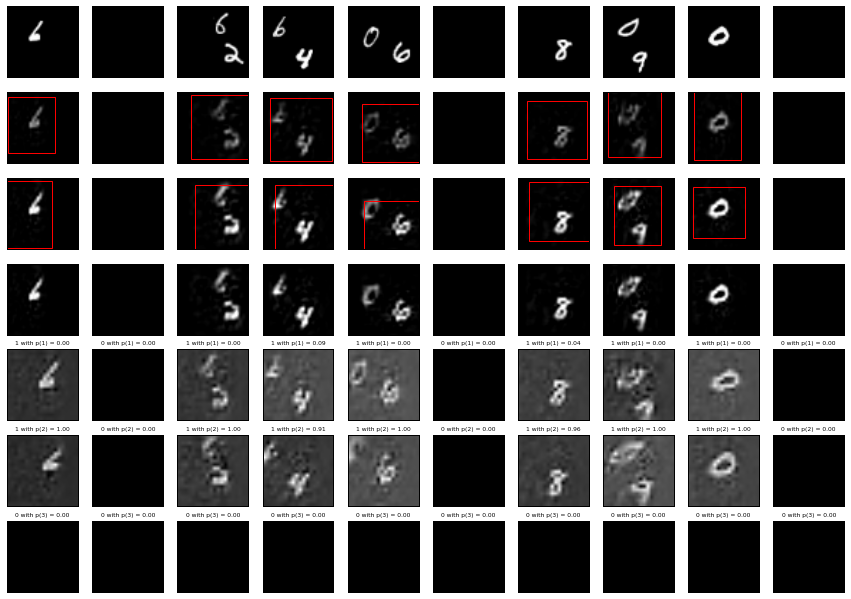

In [34]:
make_fig()